# Addressing the Ill-Posed Inverse Problem 
This tutorial picks up following the "Freyberg pilot points" tutorial in which we added a lot more adjustable parameters. We saw that this allowed us to get an excellent fit with measured data (too good!) but resulted in unrealistic parameter fields. Not to mention that we still underepresented forecast uncertainty.

## Regularization

We have more unkown parameters than observations. Thus, we have an ill-posed inverse problem. The mathematical term for the process through which a unique solution is sought for a nonunique inverse problem is “regularization”. The goal of regularised inversion is to seek a unique parameter field that results in a suitable fit between model outputs and field measurements, whilst minimizing the potential for wrongness in model predictions. That is, out of all the ways to fit a calibration dataset, regularized inversion seeks the parameter set of minimum error variance.

There are two main approaches used to stabilize this problem: 
 1) adding soft knowledge and/or 
 2) reducing the problem dimensionality. 

These methods can be used by themselves, but are most commonly applied together.


## 1. Tikhonov Regularization
We have moved up the simplicity-complexity curve because now we have many more parameters, even more than our observations.  But have we passed the sweetspot? One way to seek a parameter field of minimum error variance is to seek a parameter field that allows the model to fit the calibration dataset, but whose values are also as close as possible to a set of “preferred parameter values”.

<img src="intro_to_regularization\Hunt1998_sweetspot.png" style="float: center">

Again, it is not simply the number of parameters that is at issue.  The better way to think of it is that we just want to avoid "living beyond our means". That is, we do not bring more parameters to bear than we have the ability to constrain.  We constrain them observations as we have seen so far, but we also know things about the system that are not hard data like measurements.  This "soft-knowledge" can also be applied to  constrain our parameters through a mechanism called __"Tikhonov regularization"__.  In this formulation of the inverse problem, we add a second term to our "best fit" metric Phi. This second term reflects the deviation from our soft-knowledge of the system, and is a penalty to our fit. Here's how it looks using the Anderson et al. (2015) formulation:

<img src="intro_to_regularization\tik-reg_eq9.8.png" style="float: center">

As first term after the equal sign is our __measurement objective function__, which we've been working with all week.  The last term on the right is called the __"regularization objective function"__. These 2 terms combine to create a __total Phi__ on the left.  __Now Total Phi is what we minimize__, which means we are minimizing our observed-to-simulated residuals __AND__ the deviation from soft-knowledge.  So in this way Tikhonov regularization is a "dual-constrained minimization".  

Andrey Tikhonov
<img src="intro_to_regularization\Andrey_Tikhonov_picture.jpeg" style="float: center">

Anderson et al. (2015) looks a little closer at this in equation 9.9:


<img src="intro_to_regularization\tik-reg_eq9.9.png" style="float: center">

The first term to the right of the equals sign is the measurement objective function from
Eqn (9.6), which is calculated as the sum of squared weighted residuals, where *n* residuals,
*ri*, are calculated from hard knowledge and wi are their respective weights. The second
term quantifies the penalty resulting from deviations from soft knowledge as the sum
of *q* deviations from *j* soft knowledge conditions *fj*, where *fj* is a function of model parameters
*p*. A calibrated model, therefore, is found by minimizing both the measurement
objective function (hard data) and the soft knowledge penalty.

> __Take-home point #1 from these equations:__
> When Tikhonov is set up correctly, PEST(++) should only deviate from the preferred condition when there is a suffient improvement in our fit to the observations (= the measurement objective function).  
>
> __Take-home point #2 from these equations:__  
> The two contributors to our total $Phi$ are __*carried separately in the parameter estimation*__.  
>
This is important. It allows us to control the balance between fitting measured data and respecting expert knowledge. This is how we avoid __overfitting__.


### Prior Information

How do we express soft-knowledge quantiatively so we can minimize it?

PEST(++) provides a user with a great deal of flexibility in how Tikhonov constraints can be introduced to an inversion process. The easiest way is to do this is through the use of prior information equations. When prior information equations are employed, Tikhonov constraints are expressed through preferred values that are assigned to linear relationships between parameters. (Equality is the simplest type of linear relationship.) Weights must be assigned to these equations. As is described in PEST documentation, when PEST is run in “regularization” mode, it makes internal adjustments to the weights that are assigned to any observations or prior information equations that belong to special observation groups that are referred to as “regularization groups”. 

We add preferred conditions.  These are typically:

1. *preferred  value* - "I believe this Kh parameter is around 1 m/d"
2. *preferred difference* - "I believe  this area has a Kh 10 m/d higher than that area" 

One of the most useful preferred condition for collapsing all these parameters to fewer bins is a special case of preferred difference where the difference = 0.  This is often called: __"preferred homogeneity"__ -  which equates to something along the lines of "I believe this area has homogeneous Kh" 

Of these, __preferred value__ is the easiest implement, and least memory intensive, preferred condition.   `pyemu` implements this with functionality called "*__zero_order_tikhonov__*". (Make sure the initial values in the control file represent your soft-knowledge!) `pyemu` also has preferred difference available - look for *"__first_order_pearson_tikhonov__"*.  We'll see both of these in this notebook. We will demosntrate these functions further on.

### Pilot point regularization can be propogated to other pilot points, or not.

Here are two examples from Anderson et al. (2015).  For "preferred value" __(below (a), left)__ there is no cross-talk between pilot points.  The initial parameter value of each pilot point is the preferred value.  For preferred difference __(below (a), right)__, there is a radius of influence that connects the pilot point regularization (think correlation length from geostatistics).  


<img src="intro_to_regularization\Fig9.15a_Muffles_pp.png" style="float: center">











### Likewise, pilot-point regularization can also be grouped or limited to specific areas.  

For example, if the geology of a site suggests distinct units you can only apply the preferred difference to just the zone:

<img src="intro_to_regularization\Fig9.15b_Kyle_Larry_pp.png" style="float: center">


Here's the caption from Anderson et al. (2015) for posterity:  Figure 9.15 Pilot Points. (a) Network of pilot points in a watershed-scale groundwater flow model (left); linkages between pilot points (right) used to calculate Tikhonov regularization constraints for preferred homogeneity (modified from Muffels, 2008). (b) Network of pilot points used to represent two hydraulic conductivity zones where Tikhonov regularization is applied to pilot points within the same zone (modified from Davis and Putnam, 2013).

### But there is more to think about:

Just like our observations, our preferred conditions are given a weight.  Typically it is uniform (usually 1) - this is what the PEST utility *addreg1.exe* does. On top of this, typically we have the regularization objective function set up to adjust the weights of the different parameter groups during the course of the parameter estimation (IREGADJ variable = 1 in the PEST control file).  See pages 17, 20, and page 34 of [SIR 2010-5169](https:/pubs.usgs.gov/sir/2010/5169/). 

__But this is critical__ - these typically end up having somewhat subtle effects; the final say in trade-off between the measurement objective function and the regularization objective function is in a *user specified variable* in the PEST control file called:

__<center>PHIMLIM</center>__

Many people missed the importance of this variable in the original Doherty (2003) paper that first showed PEST's pilot points and Tikhonov capabilities. This missed importance was addressed in detail in Fienen et al. (2009).  So, for you to do good modeling with these approaches it is critically important that you take this away, so we will state it again in bigger font:  

The final say in trade-off between the measurement objective function and the regularization objective function is in a *user specified variable* in the PEST control file called:

__<center><span style=font-size:1.5em>PHIMLIM</span></center>__

PHIMLIM is the "Target Measurement Objective Function", which means rather than finding the best fit to the observations, PEST will hit this new PHIMLIM level and  *then find the minimum of the regularization objective function* (find the parameters that most closely match the preferred conditions while still keeping the PHIMLIM target measurement objective function). 

A good way to think of this is that PHIMLIM controls the trade-off between the two parts of the righthand side of the equal sign in equation 9.8 above. We can plot this tradeoff as a Pareto front between adhereing to soft-knowledge (regularization objective function) and getting a better fit (measurement objective function). That looks like:


<img src="intro_to_regularization\Fig9.17_fit_vs_softknowledge_Pareto.png" style="float: center">


A __key point__ is that many points on this curve could be considered a "calibrated model", which equals good fit and reasonable parameters. Which of these we choose is based on professional judgement. Subjective, we know.

#### Final point:  
Here's how PHIMLIM expresses itself on the optimal parameters:

<img src="intro_to_regularization\Fig9.16_PHIMLIM.png" style="float: center">

So setting PHIMLIM is our primary way to control the degree of fitting, and keep us from *overfitting*.

The suggested workflow is to:

1) Set PHIMLIM very low (e.g., 1.0) and run the parameter estimation.  This throws away the soft-knowledge and finds the best fit to the observations (minimizes the measurement objective function).  

2) Set PHIMLIM to something like __10% higher__ than this lowest Phi.  Re-run the parameter estimation, evaluate if the parameters are too extreme.  If they are, raise PHIMLIM again.

We'll use this workflow on our pilot point version of Freyberg later.  But first, let's talk a little more about the theory and implementation of ``prior_information`` in the PEST datasets.

## 2. Singular Value Decompostion

 > See the "intro to svd" notebook for an introduction to Singular Value Decompostion.

Tikhonov regularisation adds information to the calibration process in order to achieve numerical stability. In contrast, subspace methods achive numerical stability by reducing the dimensionality of the problem, removing and/or combining parameters. When employing SVD in calibration, only parameters and linear combinations of parameters that are suficiently constrained by measured data are estimated. These parameters are said to reside in the *solution space*. Choosing which parameter combinations to estimate is accomplished via singular value decomposition (SVD). SVD-based parameter estimation fixes intial values for parameters/parameter combinations that are not estimable (reside in the *null space*) and does not adjust them during inversion. (So, once again, make sure initial parameter values are sensible!)  

Unlike PEST and PEST_HP, by default, members of the PEST++ suite employ singular value decomposition (or methods closely related to it) for solution of the inverse problem. Unless otherwise specifed, default options are employed. PEST++GLM offers two numerical libraries for implementing SVD; the default option will usually suffice (see the PEST++ user manual for details).

# Back to Freyberg

Now that we have gone over a bit of theory, let's apply it to calibrating the Freyberg model. We pick up after the "freyberg pilot point run" notebook. In that tutorial, we saw that adding many more parameters made obtaining a good fit with measured data was easier. Unfortunatley, we also saw that this led to "living beyind our means". We have many more parameters than observations (ill posed inverse problem), which resulted in overfitting. Parameter values took on "unrealistic" values to compensate for structural inadequacies of the model (and parameterisation!).

Let's see if we can fix this problem with regularization.

### Admin
Load the Freyberg model and setup up the PEST control file. The next two cells construct the same setups employed during previous tutorials on pilot points.

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import psutil
import shutil

sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
tmp_d = os.path.join('freyberg_mf6')
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)
# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
hbd.prep_deps(tmp_d)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(tmp_d)
# convenience function that builds a new control file with pilot point parameters for hk
hbd.add_ppoints(tmp_d)

ins file for heads.csv prepared.
ins file for sfr.csv prepared.
noptmax:0, npar_adj:1, nnz_obs:24
written pest control file: freyberg_mf6\freyberg.pst
   could not remove start_datetime
1 pars added from template file .\freyberg6.sfr_perioddata_1.txt.tpl
6 pars added from template file .\freyberg6.wel_stress_period_data_10.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_11.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_12.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_2.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_3.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_4.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_5.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_6.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_7.txt.tpl
0 pars added from template file .\freyberg6.wel_s

In [3]:
# load the pre-constructed pst
pst = pyemu.Pst(os.path.join(tmp_d,'freyberg_pp.pst'))
# run it once for checking
pst.control_data.noptmax=0
pst.write(os.path.join(tmp_d,'freyberg_pp.pst'))
pyemu.os_utils.run('pestpp-glm freyberg_pp.pst', cwd=tmp_d)

noptmax:0, npar_adj:65, nnz_obs:37


## Tikhnov regularization as "prior information"

In pyemu, we can add two forms of regularization:
- preferred __value__: we want the parameter values to stay as close to the initial values as possible
- preferred __difference__: we prefer the differences in parameter values to be minimized

Preferred value is easy to understand, we simply add ``prior_information`` to the control file to enforce this condition.  `pyemu` uses a helper for this:

In [4]:
pst = pyemu.Pst(os.path.join(tmp_d,'freyberg_pp.pst'))
# check if it ran
assert pst.phi

You can check the `prior_information` section of the control file like so:

In [5]:
pst.prior_information

,pilbl,obgnme


As you see, it is empty. Let's add preferred value regularization:

In [6]:
# use the pyemu helper to apply preferred value regularization on all the parameters
pyemu.helpers.zero_order_tikhonov(pst,parbounds=False)

Boom!

In [7]:
# make a table of the regularization equations 
pst.prior_information.sample(10)

,pilbl,equation,obgnme,weight
42,rch_i:2_j:17_zone:1.0,1.0 * log(rch_i:2_j:17_zone:1.0) = 0.000000E+00,regulrchpp,1.0
1,wel0,1.0 * log(wel0) = 2.477121E+00,regulwel,1.0
5,wel4,1.0 * log(wel4) = 2.477121E+00,regulwel,1.0
28,hk_i:2_j:17_zone:1.0,1.0 * log(hk_i:2_j:17_zone:1.0) = 6.989700E-01,regulhk1,1.0
30,hk_i:17_j:17_zone:1.0,1.0 * log(hk_i:17_j:17_zone:1.0) = 6.989700E-01,regulhk1,1.0
51,rch_i:32_j:2_zone:1.0,1.0 * log(rch_i:32_j:2_zone:1.0) = 0.000000E+00,regulrchpp,1.0
64,rch_i:2_j:12_zone:1.0,1.0 * log(rch_i:2_j:12_zone:1.0) = 0.000000E+00,regulrchpp,1.0
3,wel2,1.0 * log(wel2) = 2.477121E+00,regulwel,1.0
13,hk_i:37_j:7_zone:1.0,1.0 * log(hk_i:37_j:7_zone:1.0) = 6.989700E-01,regulhk1,1.0
16,hk_i:12_j:12_zone:1.0,1.0 * log(hk_i:12_j:12_zone:1.0) = 6.989700E-01,regulhk1,1.0


Note the "regul_" prefix added to the parameter group name (check the `obgnme` column) - that is how we tell PEST to track the deviations from preferred conditions separately as a Tikhonov regularization.

Ok, that's fine, but should the weight on preferring a hydraulic conductivity (`hk`) value be the same as preferring recharge (`rch`) not to change? Hydraulic conductivity is typically considered to be "known" within an order of magnitude; the uncertainty in recharge is typically considered less than that - say plus or minus 50%. Seems like we would want `rch` to change less than `hk`. 

### Regularization weights from parameter prior uncertainty

There is a neat trick that `pyemu` gives us: this strength of the preferred value can be inferred from the parameter bounds you specify.  That is, the bounds are used to form the regularization weights; larger bounds = more uncertainty = less weight given to maintaining the initial value during the parameter estimation.  

Weight is calculated assuming that the range between parameter bounds reflects 4 standard deviations of the (gaussian) prior parameter probability distribution. Assigned weights are equal to the inverse of standard deviation ($\sigma$):

$$ \sigma = \frac{parubn - parlbnd}{4}$$

$$ weight = \frac{1}{\sigma} $$


> __Important__. This assumes that the parameter bounds reflect prior parameter uncertainty. So not only should the initial parmaeter value be assigned carefully, but so should the parameter bounds!

Let's try this again using the parameter bounds to specify prior information equation weights:

In [8]:
# construct preferred value reguarization equations and use the bounds to calculate the regularization weight
pyemu.helpers.zero_order_tikhonov(pst, parbounds=True)
# print out the regularization equations that were constructed
pst.prior_information.sample(10)

,pilbl,equation,obgnme,weight
pilbl,,,,
rch_i:2_j:12_zone:1.0,rch_i:2_j:12_zone:1.0,1.0 * log(rch_i:2_j:12_zone:1.0) = 0.000000E+00,regulrchpp,1.660964
rch_i:7_j:17_zone:1.0,rch_i:7_j:17_zone:1.0,1.0 * log(rch_i:7_j:17_zone:1.0) = 0.000000E+00,regulrchpp,1.660964
hk_i:12_j:17_zone:1.0,hk_i:12_j:17_zone:1.0,1.0 * log(hk_i:12_j:17_zone:1.0) = 6.989700E-01,regulhk1,0.250000
rch_i:12_j:12_zone:1.0,rch_i:12_j:12_zone:1.0,1.0 * log(rch_i:12_j:12_zone:1.0) = 0.000000E+00,regulrchpp,1.660964
hk_i:17_j:12_zone:1.0,hk_i:17_j:12_zone:1.0,1.0 * log(hk_i:17_j:12_zone:1.0) = 6.989700E-01,regulhk1,0.250000
hk_i:2_j:12_zone:1.0,hk_i:2_j:12_zone:1.0,1.0 * log(hk_i:2_j:12_zone:1.0) = 6.989700E-01,regulhk1,0.250000
rch_i:12_j:2_zone:1.0,rch_i:12_j:2_zone:1.0,1.0 * log(rch_i:12_j:2_zone:1.0) = 0.000000E+00,regulrchpp,1.660964
wel1,wel1,1.0 * log(wel1) = 2.477121E+00,regulwel,0.511707
wel0,wel0,1.0 * log(wel0) = 2.477121E+00,regulwel,0.511707


Now we are given more strength for keeping recharge near its initial value...good! This way, all else being equal, PEST(++) will "prefer" to change `hk` before it changes `rch`.

### So what about preferred difference regularization?  

Well `pyemu` can do that too.  

The simples form of "preferred difference' is homogeneity. We prefer that the "difference between parameters should equal zero". This is referred to as "first-order pearson tikhonov". But how do we assign weights? How confident are we that this a nearby parameter should have the same value? What about another parameter whic is a bit farther away? Geostatistics, that's how.

Remember that ``Cov``ariance matrix we keep talking about? It expresses the spatial relationship between pilot points (implied by the variogram), so we use to setup these prior information equations.  First we need to make a geostatistical structure to encapsulate the spatial relationships.

As we have seen in other tutorials (see the "intro to geostatistics", "intro to pyemu" and "freyberg pilot point setup" notebooks), `pyemu` can prepare a covariance matrix for spatialy distribuyted parameters, based on a geostatistical structure and variogram(s) that reflect our expert knowledge of how we expect parameters to vary. 

For example, construct a variogram:

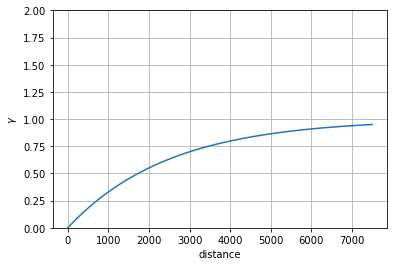

In [9]:
v = pyemu.geostats.ExpVario(contribution=1.0, a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
ax = gs.plot()
ax.grid()
ax.set_ylim(0,2.0);

Now we need to know where the pilot points are.  For this case, we can get this from the pilot point template file:

In [10]:
# make a dataframe called df_pp using pyemu helper and the pilot point template file hkpp.dat.tpl
df_pp = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(tmp_d,"hkpp.dat.tpl"))
df_pp.head()

,name,x,y,zone,parnme
0,pp_0000,625.0,9375.0,1.0,hk_i:2_j:2_zone:1.0
1,pp_0001,1875.0,9375.0,1.0,hk_i:2_j:7_zone:1.0
2,pp_0002,3125.0,9375.0,1.0,hk_i:2_j:12_zone:1.0
3,pp_0003,4375.0,9375.0,1.0,hk_i:2_j:17_zone:1.0
4,pp_0004,625.0,8125.0,1.0,hk_i:7_j:2_zone:1.0


Now let's build a covariance matrix for our pilot point parameters from the geostatistical structure:

In [11]:
# define a covariance matrix called cov using pyemu's geostatistics capabilities
cov = gs.covariance_matrix(df_pp.x, df_pp.y, df_pp.parnme)

Take a peek at the covariance matrix we just constructed:

In [12]:
cov.to_dataframe().head()

,hk_i:2_j:2_zone:1.0,hk_i:2_j:7_zone:1.0,hk_i:2_j:12_zone:1.0,hk_i:2_j:17_zone:1.0,hk_i:7_j:2_zone:1.0,hk_i:7_j:7_zone:1.0,hk_i:7_j:12_zone:1.0,hk_i:7_j:17_zone:1.0,hk_i:12_j:2_zone:1.0,hk_i:12_j:12_zone:1.0,...,hk_i:27_j:7_zone:1.0,hk_i:27_j:12_zone:1.0,hk_i:27_j:17_zone:1.0,hk_i:32_j:2_zone:1.0,hk_i:32_j:7_zone:1.0,hk_i:32_j:12_zone:1.0,hk_i:32_j:17_zone:1.0,hk_i:37_j:7_zone:1.0,hk_i:37_j:12_zone:1.0,hk_i:37_j:17_zone:1.0
hk_i:2_j:2_zone:1.0,1.000000,0.606531,0.367879,0.223130,0.606531,0.493069,0.326922,0.205741,0.367879,0.243117,...,0.078120,0.067706,0.054178,0.049787,0.047769,0.042329,0.034941,0.029143,0.026251,0.022195
hk_i:2_j:7_zone:1.0,0.606531,1.000000,0.606531,0.367879,0.493069,0.606531,0.493069,0.326922,0.326922,0.326922,...,0.082085,0.078120,0.067706,0.047769,0.049787,0.047769,0.042329,0.030197,0.029143,0.026251
hk_i:2_j:12_zone:1.0,0.367879,0.606531,1.000000,0.606531,0.326922,0.493069,0.606531,0.493069,0.243117,0.367879,...,0.078120,0.082085,0.078120,0.042329,0.047769,0.049787,0.047769,0.029143,0.030197,0.029143
hk_i:2_j:17_zone:1.0,0.223130,0.367879,0.606531,1.000000,0.205741,0.326922,0.493069,0.606531,0.164841,0.326922,...,0.067706,0.078120,0.082085,0.034941,0.042329,0.047769,0.049787,0.026251,0.029143,0.030197
hk_i:7_j:2_zone:1.0,0.606531,0.493069,0.326922,0.205741,1.000000,0.606531,0.367879,0.223130,0.606531,0.326922,...,0.127256,0.106878,0.082085,0.082085,0.078120,0.067706,0.054178,0.047769,0.042329,0.034941


It is now a simple matter of passing this matrix to `pyemu.helpers.first_order_pearson_tikhonov()`:

In [13]:
# use the pyemu helper to construct preferred difference regularization equations 
# using the covariance for regularization weight
pyemu.helpers.first_order_pearson_tikhonov(pst, cov, reset=False)

getting CC matrix
processing


Check out the new 1prior_information` equations. Note how they now reflect the _difference_ between two parameters should equal zero.

In [14]:
# check out the new regularization equations out
pst.prior_information.tail(10)

,pilbl,equation,obgnme,weight
pilbl,,,,
pcc_462,pcc_462,1.0 * log(hk_i:32_j:12_zone:1.0) - 1.0 * log(hk_i:32_j:17_zone:1.0) = 0.0,regul_cc,0.606531
pcc_463,pcc_463,1.0 * log(hk_i:32_j:12_zone:1.0) - 1.0 * log(hk_i:37_j:7_zone:1.0) = 0.0,regul_cc,0.493069
pcc_464,pcc_464,1.0 * log(hk_i:32_j:12_zone:1.0) - 1.0 * log(hk_i:37_j:12_zone:1.0) = 0.0,regul_cc,0.606531
pcc_465,pcc_465,1.0 * log(hk_i:32_j:12_zone:1.0) - 1.0 * log(hk_i:37_j:17_zone:1.0) = 0.0,regul_cc,0.493069
pcc_466,pcc_466,1.0 * log(hk_i:32_j:17_zone:1.0) - 1.0 * log(hk_i:37_j:7_zone:1.0) = 0.0,regul_cc,0.326922
pcc_467,pcc_467,1.0 * log(hk_i:32_j:17_zone:1.0) - 1.0 * log(hk_i:37_j:12_zone:1.0) = 0.0,regul_cc,0.493069
pcc_468,pcc_468,1.0 * log(hk_i:32_j:17_zone:1.0) - 1.0 * log(hk_i:37_j:17_zone:1.0) = 0.0,regul_cc,0.606531
pcc_469,pcc_469,1.0 * log(hk_i:37_j:7_zone:1.0) - 1.0 * log(hk_i:37_j:12_zone:1.0) = 0.0,regul_cc,0.606531
pcc_470,pcc_470,1.0 * log(hk_i:37_j:7_zone:1.0) - 1.0 * log(hk_i:37_j:17_zone:1.0) = 0.0,regul_cc,0.367879


What happened?  

We replace the preferred value equations with a bunch of new equations.  These equations each include two parameter names and have different weights - can you guess what the weights are?  The weights are the `pearson correlation coefficients` (CC) between the pilot points (remember those from way back?).  These CC values are calculated from the covariance matrix, which is implied by the geostatistical structure...whew! For example, ``hk_i:2_j:2_zone:1.0`` is "close" to ``hk_i:2_j:7_zone:1.0``, so they have a high CC value (equation 1).  Just for fun, go back and change the `a` parameter in the variogram and see how it changes the CC values.

> __Handy hint__:  you can use both preferred value and preferred difference regularization in the same PEST control file, and even on the same parameter!

## The Big Kahuna - PHIMLIM

And, most importantly we need to see what pyemu has for the all important regularization BIG KNOB, the target objective function - or ``phimlim``.  This is THE ONE INPUT that tells PEST how regularization is enforced.  So let's use pyemu to see what our control file has for ``phimlim``.  

In [15]:
# for the PEST control file defined by pst above, echo out phimlim
pst.reg_data.phimlim

'1.0e-10'

That is ___very low___  for a final parameter estimation.  But recall our workflow from earlier on, this value is just a "placeholder" to ignore soft knowledge and only focus on obtaining the best fit.  After the how-low-can-PEST-go run, ``phimlim`` should be set to a larger number, say the number of non-zero weighted obs (assuming that observation weights are the inverse of standard deviation of noise!).  Here we'll explore the effect of ``phimlim`` a bit.  

Now, we have already undertaken an un-regularized parameter estiamtion run. Effectively that is what we did in the "freyberg pilot point run" notebook. We got a really good fit - much better than is reasonable give the uncertainty (e.g. noise) in our observation data (check the previous notebook to get the value of Phi).

How many non-zero weighted observations do we have?

In [16]:
nnz_obs = pst.nnz_obs
nnz_obs

37

A convenience of weighting with the inverse of the measurement uncertainty (which we have done in this case) is that it is easy to know what the ideal Phi should be: it should be equal to the number of non-zero weighted observations. 

This of course assumes that all model-to-measurment misfit is due to *measurement* uncertainty. In practice, model error usualy plays a larger role, as we will see in other tutorials. 

So, let's assign PHILIM equal tot he number of non-zero weighted observations:

In [17]:
pst.reg_data.phimlim = nnz_obs
pst.reg_data.phimlim

37

When chaning PHIMLIM, we must also change PHIMACCEPT. This is the level of acceptable "measurement objective function". If PEST(++) achieves PHIMLIM, it will then attempt to minimize the _regularisation_ objective function, whilst maintaining the _measurment_ objective function below PHIMACCEPT.

Ideally, PHIMACCEPT should be assigned 5-10% higher than PHIMLIM.

In [18]:
# when phimlim changes so should phimaccept, and is usually 5-10% higher than phimlim
pst.reg_data.phimaccept = 1.1 * pst.reg_data.phimlim
pst.reg_data.phimaccept

40.7

One last important detail! Make sure we set the `pestmode` to regularization. This should have happened by default when we used the `pyemu.helpers` to assign prior information equations.

In [19]:
assert pst.control_data.pestmode == 'regularization'
pst.control_data.pestmode

'regularization'

## Write and Run

Sheesh - this was a long one. Hope you are still with us. Let's now re-write the PESt control file and run it!

In [20]:
pst.control_data.noptmax=20

We need to remove some PEST++ optional variables (we haven't mentioned these before; they control PEST++GLM SVD-Assist options. We shan't discuss these here. See tutorials on PEST++GLM in Part2 of these tutorial notebooks for more information.)

In [21]:
pst.pestpp_options.pop('n_iter_base')
pst.pestpp_options.pop('n_iter_super')

'3'

Write the control file again:

In [22]:
pst.write(os.path.join(tmp_d, 'freyberg_reg.pst'))

noptmax:20, npar_adj:65, nnz_obs:37


Remember to specify the number which is adequate for ***your*** machine! Make sure to assign an appropriate value for the following `num_workers` variable. (If you are unsure how many cores you have, you can use `psutil` to check).

In [23]:
psutil.cpu_count(logical=False)

10

In [24]:
# set the number of parallel agents
num_workers = 10
# set the master directory
m_d='master_reg'

In [25]:
pyemu.os_utils.start_workers(tmp_d, # the folder which contains the "template" PEST dataset
                            'pestpp-glm', #the PEST software version we want to run
                            'freyberg_reg.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

## Outcomes

Re-load the control file and check the new Phi:

In [26]:
pst = pyemu.Pst(os.path.join(m_d, 'freyberg_reg.pst'))
pst.phi

40.166057159349315

That number looks familiar...what did we assing to PHIMACCEPT again?

In [27]:
pst.reg_data.phimaccept

40.7

Check out the Phi progress. Interesting. In this case PEST managed to get a fit better than PHIMLIM in the very first iteration (not a usual case). Measurment Phi then increases up to PHIMACCEPT. Subsequent iterations were spent reducing regularization Phi untill total Phi is lower than PHIMLIM.

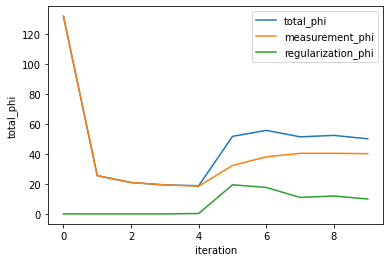

In [28]:
df_obj = pd.read_csv(os.path.join(m_d,"freyberg_reg.iobj"),index_col=0)
df_obj.plot(y=['total_phi','measurement_phi','regularization_phi'])
plt.ylabel('total_phi');

What about the fits with measured values? Not perfect...but we aren't looking for a perfect fit here - we are looking for _as good a fit_ as the measured data justifies.

<Figure size 576x756 with 0 Axes>

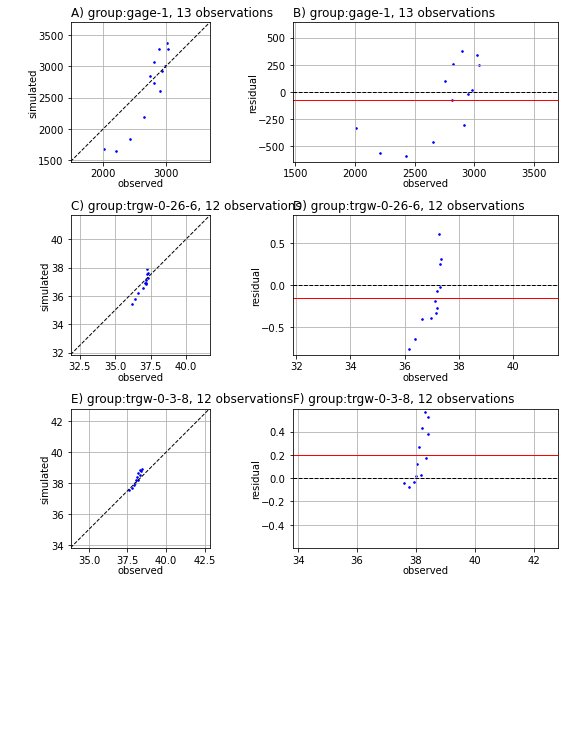

In [29]:
figs = pst.plot(kind="1to1");

Let's inspect the posterior parameter uncetanties for each parameter group. 

The next cell plots the prbability distribution for each parameter in each parameter group. Recall that each pilot point is assigned a unique parmaeter, so in each plot we are displaying multiple distributions. We are also plotting the parmater upper and lower bounds as vertical dashed black lines.

In [30]:
def plot_param_unc():
    par = pst.parameter_data
    df_paru = pd.read_csv(os.path.join(m_d,"freyberg_reg.par.usum.csv"),index_col=0)

    fig, axes=plt.subplots(1,len(pst.adj_par_groups),figsize=(12,5))
    i=0
    for pargp in pst.adj_par_groups:
        ax = axes[i]
        i+=1
        hk_pars = [p for p in pst.par_names if p.startswith("hk")]
        pars = par.loc[par.pargp==pargp].parnme.values
        df_par = df_paru.loc[pars,:]
        ax = pyemu.plot_utils.plot_summary_distributions(df_par,label_post=False, ax=ax)
        mn = np.log10(pst.parameter_data.loc[pars[0].lower(),"parlbnd"])
        mx = np.log10(pst.parameter_data.loc[pars[0].lower(),"parubnd"])
        ax.set_title(pargp)
        ax.plot([mn,mn],ax.get_ylim(),"k--")
        ax.plot([mx,mx],ax.get_ylim(),"k--")

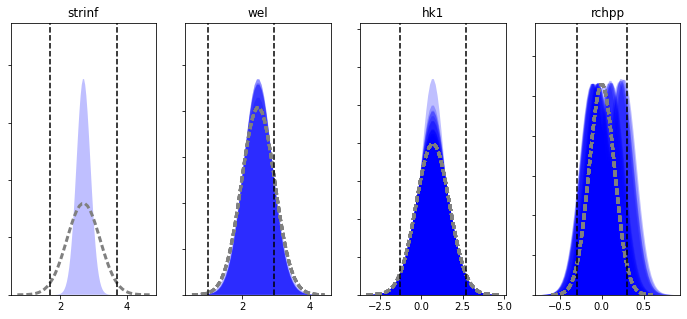

In [31]:
plot_param_unc()

A lot better than before! We are no longer getting lots pf parameters at their bounds. Yay.


Let's take a look at the calibrated parameter K field. First we just need to update the model files with the calibrated parameter values:

In [32]:
pst.parrep(os.path.join(m_d, "freyberg_reg.par" ))
pst.write_input_files(pst_path=m_d)
pyemu.geostats.fac2real(os.path.join(m_d,"hkpp.dat"),
                        factors_file=os.path.join(m_d,"hkpp.dat.fac"),
                        out_file=os.path.join(m_d,"freyberg6.npf_k_layer1.txt"))

Updating parameter values from master_reg\freyberg_reg.par
parrep: updating noptmax to 0


'master_reg\\freyberg6.npf_k_layer1.txt'

In [33]:
pyemu.os_utils.run('python forward_run.py', cwd=m_d)

And then use `flopy` to plot:

In [34]:
df_pp = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(m_d,"hkpp.dat.tpl"))
sim = flopy.mf6.MFSimulation.load(sim_ws=m_d, verbosity_level=0) #modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=[])
gwf= sim.get_model()

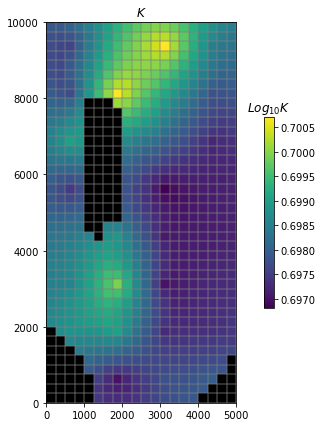

In [35]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)

k = gwf.npf.k.get_data()
vmax=40
vmin=2
ca = mm.plot_array(np.log10(k), masked_values=[1e30],)#vmax=np.log10(vmax), vmin=np.log10(vmin))
cb = plt.colorbar(ca, shrink=0.5)
cb.ax.set_title('$Log_{10}K$')

mm.plot_grid(alpha=0.5)
mm.plot_inactive()
ax.set_title('$K$');

Hey! Whats this?! nearly uniform K?? Oh right...thats what we told PEST we preferred. Therefore parameter values were left alone, unless needed to improve the fit.

What about recharge? Remember from the posterior parameter distributions plotted above, we see `rch` parameter values deviated from the prior the most.

Plot recharge spatial distribution:

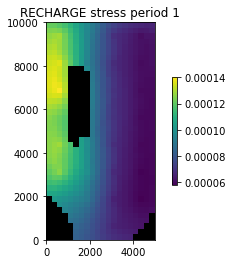

In [36]:
gwf.rch.plot();

So, although we specified that `hk` parameters were more uncertain than `rch`, information content in the observation data required changes in `rch`. Because `hk` and `rch` are correlated...only one is changed.

Is this reasonable? This is where your expert knowledge comes in. If not, perhaps we need to back off on the fit a bit more.

And as usual, we return to our forecasts. Have we done better this time?

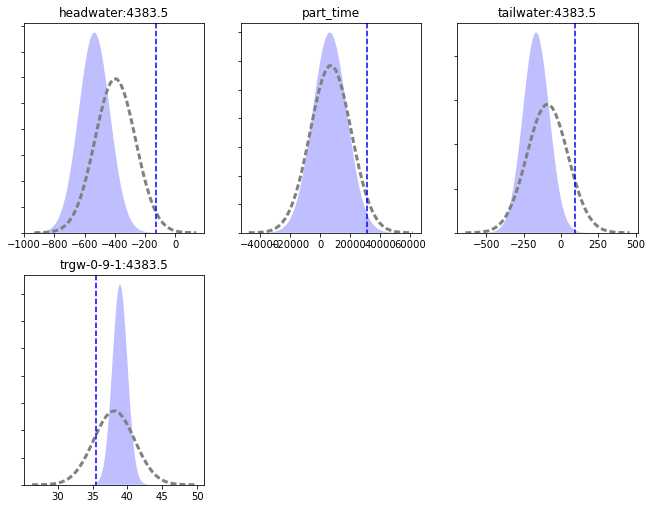

In [37]:
def plot_forecast_unc():
    figs, axes = pyemu.plot_utils.plot_summary_distributions(os.path.join(m_d,
                        "freyberg_reg.pred.usum.csv"),subplots=True, )
    for ax in axes:
        fname = ax.get_title().lower()
        ylim = ax.get_ylim()
        v = pst.observation_data.loc[fname,"obsval"]
        ax.plot([v,v],ylim,"b--")
        ax.set_ylim(0, ylim[-1])
    fig.tight_layout()

plot_forecast_unc()

Better...maybe? But still failing. How is this possible?!

## Model-to-Measurement Misfit is not just Measurement Noise

We specified PHIMLIM to ensure that, at best, PEST would achieve a fit _as good_ as ___measured___ data quality justified. This assumes that the model is actually able to schieve such a fit! 

But! in practice, measurement noise is only one component of model-to-measurment misfit. The other is ___model error___. We are trying to get an ideal fit, with an imperfect model. Perhaps a higher PHIMLLIM would be a more reliable approach. Given the odd parameter distributions above, makes sense.

But what value to use...How will we know we have eliminated the overfitting problem? Well..in the real-world, we will never know. In practice, this is where your professional judgment comes in. The modeller must decide what is a justifiable level of fit given the models' limitations.

In [38]:
pst = pyemu.Pst(os.path.join(tmp_d, 'freyberg_reg.pst'))

In [39]:
pst.reg_data.phimlim = nnz_obs * 2
# when phimlim changes so should phimaccept, and is usually 5-10% higher than phimlim
pst.reg_data.phimaccept = 1.1 * pst.reg_data.phimlim
#check values
pst.reg_data.phimlim, pst.reg_data.phimaccept

(74, 81.4)

Run PEST again:

In [40]:
pst.control_data.noptmax = 20
pst.write(os.path.join(tmp_d, 'freyberg_reg.pst'))

pyemu.os_utils.start_workers(tmp_d, # the folder which contains the "template" PEST dataset
                            'pestpp-glm', #the PEST software version we want to run
                            'freyberg_reg.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

noptmax:20, npar_adj:65, nnz_obs:37


And load it back in again:

In [41]:
pst = pyemu.Pst(os.path.join(m_d, 'freyberg_reg.pst'))
pst.phi

74.43369509853959

Now we see that parameters have not deviated as much from the intial values. Not surprising, since we set the PHIMLIM so high.

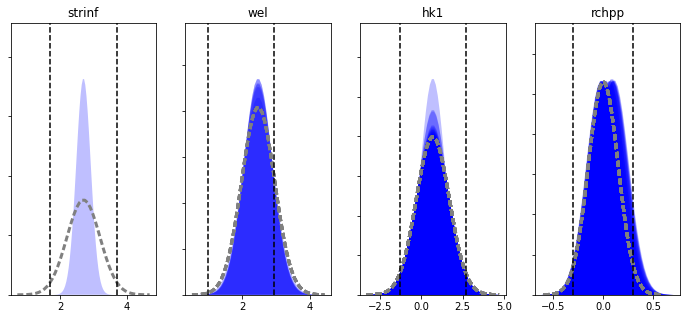

In [42]:
plot_param_unc()

And now the forecasts.

There we go! For the first time we aren't (entirely) failing to capture the truth values in the posterior forecast distributions. (_Although, it is a bit tenuous...are we including enough adjustable parameters in our uncertainty analysis?_)

So, what has happened here? Effectively we have traded a good fit with measured data for larger forecast uncertainty. So, even though we aren't fitting the observations as well, we are doing much better from a model forecast reliability stand point. 

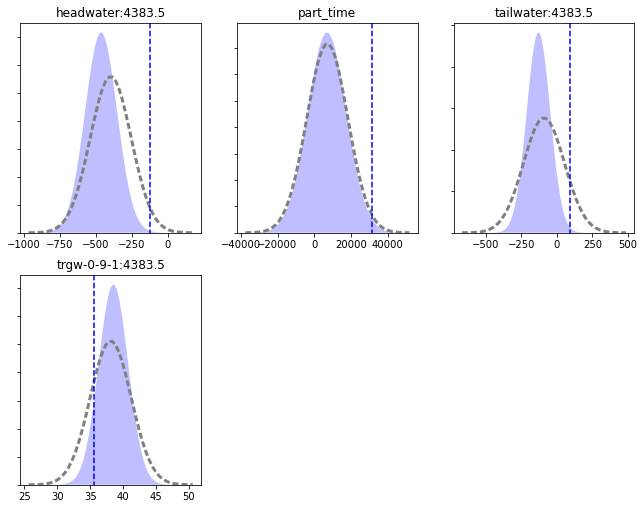

In [43]:
plot_forecast_unc()